# xgcm examples for CMIP6 models

In this notebook I want to demonstrate how to use xgcm to compute:
 - SST gradient
 - Surface vorticity (curl)

for most models in the CMIP6 experiment in an efficient way.
 

Unfortunately the biggest part of the notebook is actually renaming the model datasets and recreating grid variables that are necessary for such calculations. But this might still be helpful.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import xarray as xr
import gcsfs
from xgcm import Grid

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina' 

In [2]:
# from dask.distributed import Client

# client = Client("tcp://10.32.168.12:43841")
# client

In [3]:
# Go through the catalogue
import pandas as pd
df = pd.read_csv('https://storage.googleapis.com/pangeo-cmip6/pangeo-cmip6-zarr-consolidated-stores.csv')

pick = dict()
# variables = ['thetao', 'uo', 'vo', 'thkcello']
variables = ['thetao', 'uo', 'vo']
for var in variables:
    # pick all available 'piControl' experiements with ocean temperature fields
    pick[var] = df[ (df.variable_id == var) & (df.experiment_id == 'piControl') &
            (df.grid_label == 'gn')
         ]

In [4]:
# build a path dictionary
import numpy as np
# path_dict = {model:{} for model,uri in zip(pick['source_id'].values, pick['zstore'].values)}
models = np.unique(np.concatenate([p['source_id'].values.flat for p in list(pick.values())]))#
path_dict = {model:{} for model in models}
for var in pick.keys():
    for model, uri in zip(pick[var]['source_id'].values, pick[var]['zstore'].values):
        path_dict[model][var] = uri
# # this is an unstructured grid...we cant process that yet
del path_dict['AWI-CM-1-1-MR']

# sort out models that have all three variables 
#(seems to be that the velocity is missing for some, in some cases even just v???)
path_dict = {k:v for k,v in path_dict.items() if set(v.keys()) == set(variables)}

# # testing
# path_dict = {k:v for k,v in path_dict.items() if k in ['GFDL-CM4']}

path_dict.keys()

dict_keys(['BCC-CSM2-MR', 'BCC-ESM1', 'CAMS-CSM1-0', 'CESM2', 'CESM2-WACCM', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'CanESM5', 'EC-Earth3', 'EC-Earth3-Veg', 'GFDL-CM4', 'GISS-E2-1-G', 'GISS-E2-1-G-CC', 'HadGEM3-GC31-LL', 'MCM-UA-1-0', 'MIROC-ES2L', 'MIROC6', 'NESM3', 'SAM0-UNICON'])

In [5]:
# read the data (lazily) into dictionary
def read_data(uri_dict):
    datasets = {}
    for k,v in uri_dict.items():
#         print("reading: %s" %k)
        gcs = gcsfs.GCSFileSystem(token='anon')
        ds = xr.open_zarr(gcs.get_mapper(v), consolidated=True)
        datasets[k] = ds
    return datasets

data_dict = dict()
for k,v in path_dict.items():
    print(k)
    if k not in ['EC-Earth3-LR']:
        data_dict[k] = read_data(v)

BCC-CSM2-MR
BCC-ESM1
CAMS-CSM1-0
CESM2
CESM2-WACCM
CNRM-CM6-1


/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/coding/times.py:459: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/coding/times.py:459: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/coding/tim

CNRM-ESM2-1


/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/coding/times.py:459: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/coding/times.py:459: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/coding/tim

CanESM5
EC-Earth3


/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/coding/times.py:459: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/coding/times.py:459: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/coding/tim

EC-Earth3-Veg


/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/coding/times.py:459: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/coding/times.py:459: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/coding/tim

GFDL-CM4
GISS-E2-1-G
GISS-E2-1-G-CC
HadGEM3-GC31-LL
MCM-UA-1-0
MIROC-ES2L


/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/coding/times.py:459: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/coding/times.py:459: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/coding/tim

MIROC6


/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/coding/times.py:459: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


NESM3
SAM0-UNICON


## Homogenizing the datasets + Recreating grid metrics:

Most CMIP datasets are organized in the same way, yet the same properties are named differently (WHHHYYYYYYY????). 
I wrote a manual renaming function to make all datasets homogenous. For details see `preprocessing.py`

Unfortunately the CMIP6 archive does not include most of the grid "metrics" (cell face distance etc), nor do the data have the correct staggered grid.
We have to rebuild them. For details on how to do that with xgcm see `recreate_grids.py` 

In [6]:
from preprocessing import broadcast_lonlat, cmip6_renaming_dict, cmip6_homogenization
from recreate_grids import merge_variables_on_staggered_grid, recreate_metrics

renaming_dict = cmip6_renaming_dict()

def full_preprocessing(dat_dict, modelname, plot=False, verbose=False):
    # homogenize the naming
    dat_dict = {var: cmip6_homogenization(data, renaming_dict[modelname]) for var, data in dat_dict.items()}
    
    # broadcast lon and lat values if they are 1d
    if renaming_dict[modelname]['lon'] is None:
        dat_dict = {var: broadcast_lonlat(data) for var, data in dat_dict.items()}
    
    # merge all variables together on the correct staggered grid
    ds = merge_variables_on_staggered_grid(dat_dict, modelname, plot=plot, verbose=verbose)
    
    grid_temp = Grid(ds)
    ds = recreate_metrics(ds, grid_temp)
    return ds
    

data_final = {}
for modelname, v_dict in data_dict.items():
    print(modelname)
    data_final[modelname] = full_preprocessing(v_dict, modelname)

BCC-CSM2-MR
Grid Type: B detected


/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


BCC-ESM1
Grid Type: B detected


/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


CAMS-CSM1-0
Grid Type: B detected
CESM2
Grid Type: B detected
CESM2-WACCM
Grid Type: B detected
CNRM-CM6-1
Grid Type: C detected
CNRM-ESM2-1
Grid Type: C detected
CanESM5
Grid Type: C detected
EC-Earth3
Grid Type: C detected
EC-Earth3-Veg
Grid Type: C detected
GFDL-CM4


/home/jovyan/cmip6-hackathon-demos/notebooks/preprocessing.py:30: UserWarning: Variable [lon_bnds] not found in Coordinates:
  * bnds       (bnds) float64 1.0 2.0
    lat        (y, x) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
  * lev        (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
    lev_bnds   (lev, bnds) float64 dask.array<chunksize=(35, 2), meta=np.ndarray>
    lon        (y, x) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
  * time       (time) object 0151-01-16 12:00:00 ... 0650-12-16 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(6000, 2), meta=np.ndarray>
  * x          (x) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * y          (y) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
  warnings.warn('Variable [%s] not found in %s' %(dim_name_di[di], ds.coords))
/home/jovyan/cmip6-hackathon-demos/notebooks/preprocessing.py:30: UserWarning: Variable [lat_bnds] not found in Coordinat

Grid Type: A detected
GISS-E2-1-G
Grid Type: C detected


/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


GISS-E2-1-G-CC
Grid Type: C detected
HadGEM3-GC31-LL
Grid Type: C detected
MCM-UA-1-0
Grid Type: B detected


/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


MIROC-ES2L
Grid Type: B detected


/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


MIROC6
Grid Type: B detected


/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


NESM3
Grid Type: C detected
SAM0-UNICON
Grid Type: B detected


## Ok now the fun can begin

This is where xgcm comes in. Usually you would find all the metrics already saved as model output.

First we need to create a grid object for each model. These have to match since all the information about a particular grid is stored in the corresponding grid object. I chose to organize them in a dictionary just like the data

In [7]:
# create xgcm grids for each model
def create_grid(ds):
    grid = Grid(ds, metrics={
        ('X',):[a for a in ds.coords if 'dx' in a ],
        ('Y',):[a for a in ds.coords if 'dy' in a ],
#         ('Z',):[a for a in ds.coords if 'dz' in a ], #activate later?
        ('X','Y'):[a for a in ds.coords if 'area_' in a ],
    })
    # TODO: SHould probably turn off periodicity for Y
    return grid

grids = {k: create_grid(v) for k, v in data_final.items()}

### Temperature Gradient
As a first example we can look at the SST gradient magnitude

In [8]:
# Define a little helper function
# Note there is nothing about the specific grid in here, and we will apply this to each model in the experiment!

def total_gradient(data, grid):
    dt_dx = grid.derivative(data, 'X')
    dt_dy = grid.derivative(data, 'Y')
    return (grid.interp(dt_dx, 'X')**2 + grid.interp(dt_dy,'Y')**2) ** 0.5

BCC-CSM2-MR
BCC-ESM1
CAMS-CSM1-0
CESM2
CESM2-WACCM
CNRM-CM6-1
CNRM-ESM2-1
CanESM5
EC-Earth3


/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)


EC-Earth3-Veg


/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)


GFDL-CM4
GISS-E2-1-G
GISS-E2-1-G-CC
HadGEM3-GC31-LL
MCM-UA-1-0
MIROC-ES2L
MIROC6
NESM3


/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)


SAM0-UNICON


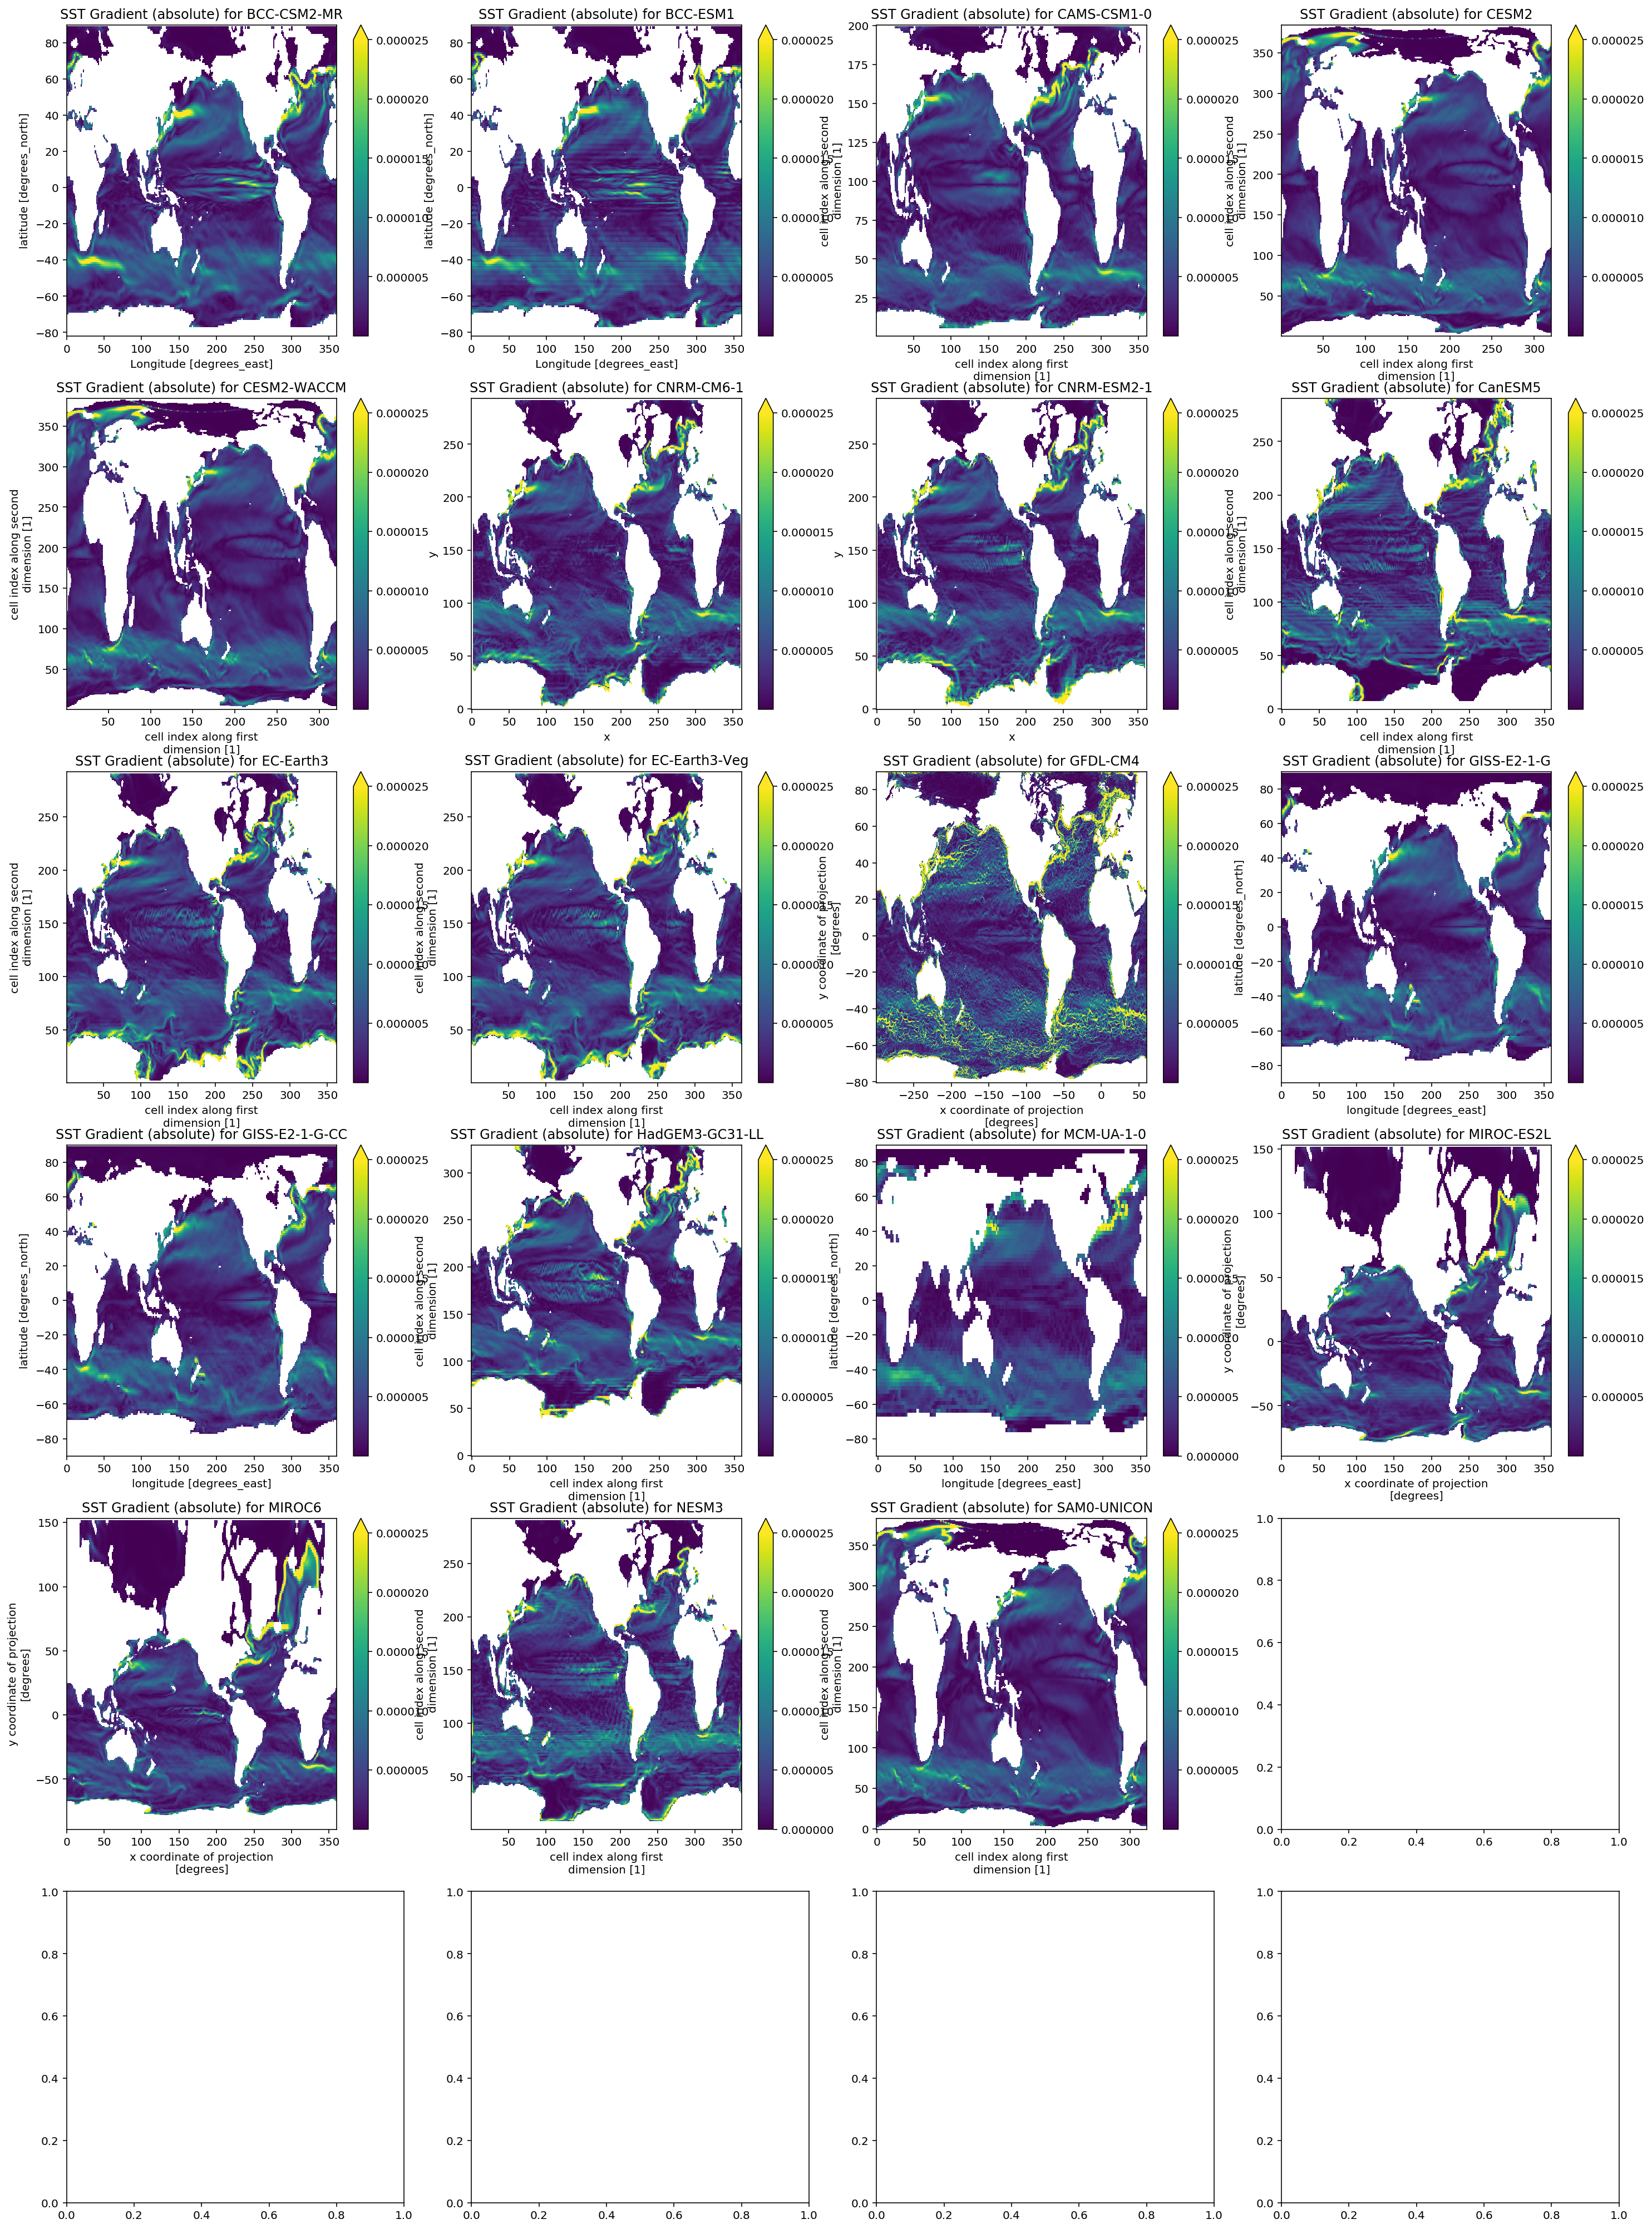

In [9]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig, axarr = plt.subplots(
    ncols=4, nrows=6,
    figsize=[25, 36],
#     subplot_kw={"projection": ccrs.Robinson(180)} # Currently I am still having trouble with cartopy...
)
# Loop over all models, compute the surface temp gradient (only for the first time step) and plot
for ax, (k, ds) in zip(axarr.flat, data_final.items()): 
    print(k)
    grad = total_gradient(ds.thetao.isel(time=0, lev=0), grids[k])
    # xgcm currently wipes all coords, so we have to replace them
    for co in ['lon', 'lat']:
        grad.coords[co] = ds[co]
        
    grad.plot(
        ax=ax,
#         x='lon', y='lat', 
#         transform=ccrs.PlateCarree(),
        vmax=2.5e-5
    )
    ax.set_title("SST Gradient (absolute) for %s" % k)
#     ax.set_global()
#     ax.add_feature(cfeature.LAND, edgecolor='0.6')

In [13]:
def curl(u,v, grid):
    dv_dx = grid.derivative(v,'X')
    du_dy = grid.derivative(u,'Y')
    # If this is not on the ne corner already (c-grid), this
    # could be interpolated to the ne corner or tracer point..
    if set(dv_dx.dims) != set(du_dy.dims):
        dv_dx = grid.interp(dv_dx, 'Y')
        du_dy = grid.interp(du_dy, 'X')
    return dv_dx - du_dy

BCC-CSM2-MR
BCC-ESM1
CAMS-CSM1-0
CESM2
CESM2-WACCM
CNRM-CM6-1
CNRM-ESM2-1
CanESM5
EC-Earth3


/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


EC-Earth3-Veg


/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


GFDL-CM4
GISS-E2-1-G
GISS-E2-1-G-CC
HadGEM3-GC31-LL
MCM-UA-1-0
MIROC-ES2L
MIROC6
NESM3


/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)


SAM0-UNICON


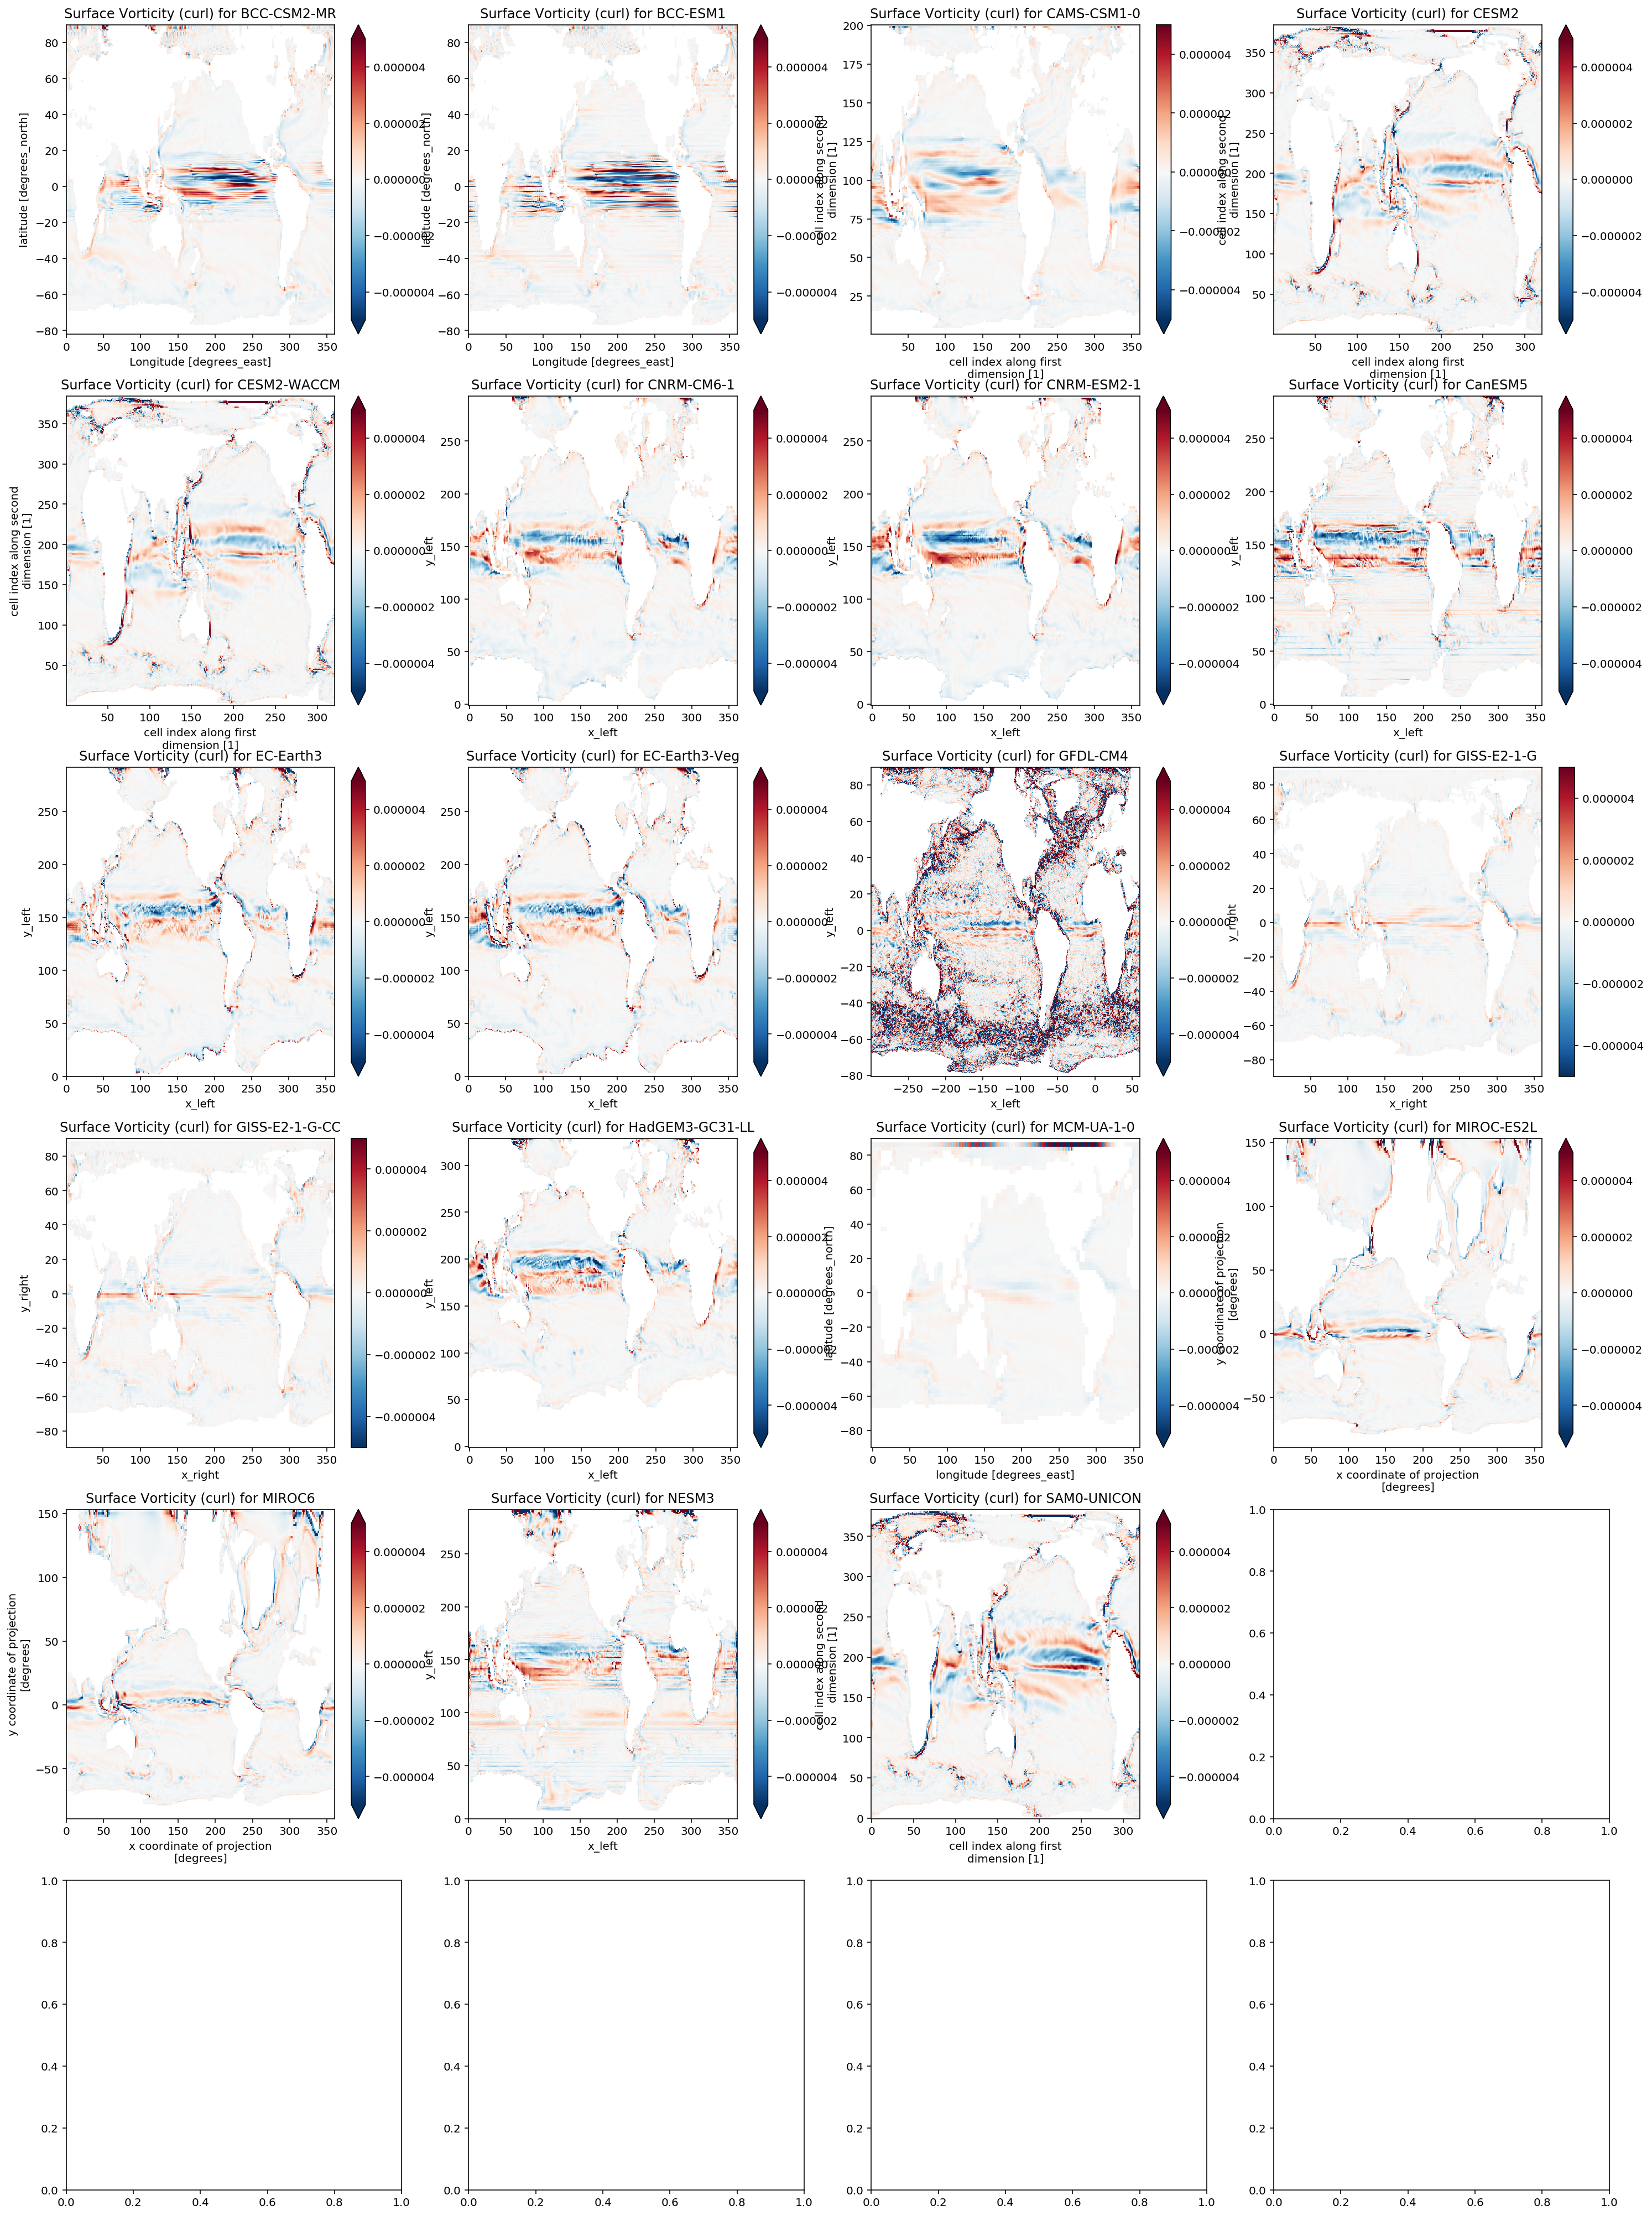

In [18]:
fig, axarr = plt.subplots(
    ncols=4, nrows=6,
    figsize=[25, 36],
#     subplot_kw={"projection": ccrs.Robinson(180)} # Currently I am still having trouble with cartopy...
)
# Loop over all models,
# compute the surface curl (only for the first time step) and plot
for ax, (k, ds) in zip(axarr.flat, data_final.items()): 
    print(k)
    zeta = curl(ds.uo, ds.vo, grids[k]).isel(time=0, lev=0)
    # xgcm currently wipes all coords, so we have to replace them
#     for co in ['lon', 'lat']:
#         grad.coords[co] = ds[co]
        
    zeta.plot(
        ax=ax,
#         x='lon', y='lat', 
#         transform=ccrs.PlateCarree(),
        vmax=5e-6
    )
    ax.set_title("Surface Vorticity (curl) for %s" % k)
#     ax.set_global()
#     ax.add_feature(cfeature.LAND, edgecolor='0.6')

Look at all those georgeous eddies in the GFDL model!

Something funky is going on in several of these models with the surface velocities...definitely warrants a closer look.

Several grids seem to pose problems for cartopy, which is why I turned the projection off above. Once that is fixed we will have a much more pleasant plot

The other examples will have to wait until I can run this in the cloud...

## Additional QC plots

Checking on the reconstruction of the grid metrics

In [ ]:
def grid_metric_plot(ds):
    fig, axarr = plt.subplots(ncols=4, nrows=3, figsize=[20, 10])
    for ax, var in zip(axarr.flat, ['dxt', 'dxe', 'dxne', 'dxn',
                               'dyt', 'dye', 'dyne', 'dyn',
                               'area_t', 'area_e', 'area_ne', 'area_n']):
        ds[var].plot(ax=ax)
        
for k, ds in data_final.items():
    grid_metric_plot(ds)
    plt.suptitle(k)